### Adaptive Hyperparameter Optimization with Dask-ML

This notebook demonstrates Hyperband, a model selection algorithm now part of Dask-ML. It showcases:

* **Problem:** Tuning hyperparameters for good model performance.
* **Realistic Use Case:** Image denoising with a deep learning model.
* **Hyperparameter Optimization:**
    * Explores parameter space with Hyperband.
    * Compares with early stopping techniques.
* **Results Visualization:**
    * Analyzes input/output data.
    * Visualizes best model's performance.

### Importance of Hyperparameter Tuning

Any machine learning model requires tuning hyperparameters for optimal performance. This notebook focuses on image denoising, where crucial parameters include:

```python
params = {
    'module__init': ['xavier_uniform_', 'xavier_normal_', 'kaiming_uniform_', 'kaiming_normal_'],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}


These parameters control:

* Model initialization
* Activation function
* Optimizer and its hyperparameters (learning rate, momentum, etc.)
* Batch size

In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [2]:
# !export PYTHONPATH=../src:$PYTHONPATH
# !echo $PYTHONPATH
!cp -u ../src/noisy_mnist.py . 


In [3]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2024-02-07


In [4]:
import os
path = "/".join(os.getcwd().split("/")[:-1])
results_folder = f"data/results/skorch_run/{today}"
absolutepath_to_results = os.path.join(path,results_folder)
os.makedirs(absolutepath_to_results,exist_ok=True)


In [5]:
import socket
s=socket.socket()
s.bind(("", 0))
port = s.getsockname()[1]
s.close()

In [6]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

In [7]:
cluster = LocalCUDACluster(dashboard_address=f"127.0.0.1:{port}")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:33325/status,
Dashboard: http://127.0.0.1:33325/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45399,Workers: 2
Dashboard: http://127.0.0.1:33325/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:40671,Total threads: 1
Dashboard: http://127.0.0.1:33789/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:42051,


In [8]:
%time client.upload_file('../models/autoencoder.py')

CPU times: user 1.64 s, sys: 343 ms, total: 1.98 s
Wall time: 3.93 s


{'tcp://127.0.0.1:35239': {'status': 'OK'},
 'tcp://127.0.0.1:40671': {'status': 'OK'}}

In [9]:
import dask_ml
print (f'Dask ml version : {dask_ml.__version__}' ) 

Dask ml version : 2023.3.24


### Dataset and Model

* **Dataset:** Noisy MNIST images for denoising.
* **Model:** Deep learning autoencoder with a latent dimension of 49.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [11]:
import noisy_mnist
chunk_size = 70_000 // 3
_X, _y = noisy_mnist.dataset()
_X = _X[:chunk_size * 3]
_y = _y[:chunk_size * 3]

In [12]:
_X.shape, _X.dtype, _X.min(), _X.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [13]:
_y.shape, _y.dtype, _y.min(), _y.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [14]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>,
 dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>)

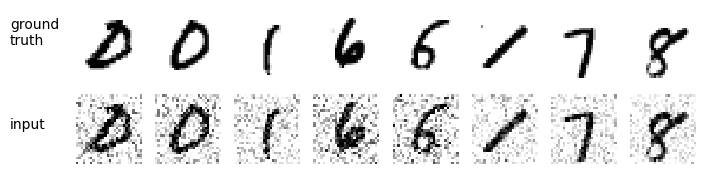

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

rng = check_random_state(42)
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = rng.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig(f"{absolutepath_to_results}/input-output.svg", bbox_inches="tight")
plt.show()

### Model Architecture

The autoencoder model uses PyTorch through the scikit-learn interface [skorch].

[skorch]:https://github.com/dnouri/skorch

In [16]:
from autoencoder import Autoencoder, NegLossScore
import torch


def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

### Hyperparameter Optimization Setup

* Uses Dask for distributed computing.
* Defines parameter search space (`params`).
* Sets random state for reproducibility.

##### Parameters

The parameters interesting in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD

In [17]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

Testing `optimizer` to be `SGD` or `Adam` comes from here "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [18]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [19]:
import json

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [20]:

import msgpack

def save_search(search, today, prefix, X, y):
    # create the folder into results and direct the results over there
    path = "/".join(os.getcwd().split("/")[:-1])
    results_folder = f"results/skorch_run/{today}"
    absolutepath_to_results = os.path.join(path,results_folder)
    os.makedirs(absolutepath_to_results,exist_ok=True)
    pre = f"{absolutepath_to_results}/{today}-{prefix}-"


    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        y_hat = y_hat.compute()
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k and "param_distribution" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

### Hyperparameter Optimization Algorithms

Compares different optimization algorithms:

* **Hyperband:** Efficiently explores and exploits the parameter space.
* **Hyperband with Successive Overfitting Prevention (SOP):** Early stops models that don't improve, potentially reducing wasted evaluations.
* **Incremental Search with Patience:** Adaptively adds and removes models based on performance.

#### Data Exploration

Visualizes noisy and clean images to understand the task.

In [21]:
X

dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>

In [22]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(7002, 784), dtype=float32, chunksize=(2334, 784), chunktype=numpy.ndarray>)

In [23]:
y_train

dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>

In [24]:
from sklearn.linear_model import SGDClassifier

max_iter = 250 # originally this number was 250 to make a decent denoising 
history = {}
cv_results = {}
searches = {}

In [25]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperparameter Tuning with Hyperband

Trains the model with Hyperband and analyzes the results:

* Best model parameters
* Best model score
* Visualizations of the best model's output

In [26]:
search = HyperbandSearchCV(model, params, max_iter, random_state=42)

In [27]:
y_train.shape

(62997, 784)

In [28]:
%%time
search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 2.202204704284668
steps = 1, loss = 1.0604509115219116
steps = 1, loss = 2.0787689685821533
steps = 1, loss = 1.9983878135681152
steps = 1, loss = 2.9078874588012695
steps = 1, loss = 2.1339221000671387
steps = 1, loss = 49.96958923339844
steps = 1, loss = 1.6027408838272095
steps = 1, loss = 1.6714401245117188
steps = 83, loss = 2.4591171741485596
steps = 83, loss = 2.6524462699890137
steps = 83, loss = 2.4868273735046387
steps = 83, loss = 3.1829371452331543
steps = 83, loss = 2.051856279373169
steps = 83, loss = 4.839390277862549
steps = 1, loss = 2.002286911010742
steps = 1, loss = 1.0298068523406982
steps = 1, loss = 0.7160890102386475
steps = 1, loss = 1.9761333465576172
steps = 1, loss = 2.0289371013641357
steps = 1, loss = 1.9753522872924805
steps = 83, loss = 3.903987169265747
steps = 83, loss = 2.9585912227630615
steps = 83, loss = 50.01108932495117
steps = 250, loss = 2.5863118171691895
steps = 250, loss = 5.067054271697998
steps = 250, loss = 3.46138858795

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=250,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  random_state=42)

In [29]:
# timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [30]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [31]:
search.best_score_

-1.9401624202728271

In [32]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.0009119267598459299,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.25725725725725723,
 'optimizer__lr': 6.915758828738525,
 'optimizer': 'SGD',
 'module__init': 'xavier_normal_',
 'module__activation': 'LeakyReLU',
 'batch_size': 256}

In [33]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

### Hyperband with SOP

Trains the model with Hyperband with SOP and analyzes the results.


In [34]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=42, patience=True)

In [35]:
%%time
search_patience.fit(X_train, y_train, **fit_params)

steps = 1, loss = 1.976102590560913
steps = 1, loss = 2.0065276622772217
steps = 1, loss = 2.022500514984131
steps = 1, loss = 1.1510610580444336
steps = 1, loss = 1.9715073108673096
steps = 1, loss = 0.7229595184326172
steps = 84, loss = 2.7753853797912598
steps = 84, loss = 2.7443578243255615
steps = 84, loss = 3.6286063194274902
steps = 84, loss = 3.589615821838379
steps = 1, loss = 2.0105245113372803
steps = 1, loss = 2.005730390548706
steps = 1, loss = 1.9459617137908936
steps = 1, loss = 1.0126945972442627
steps = 1, loss = 1.6624188423156738
steps = 1, loss = 49.70864486694336
steps = 1, loss = 1.7215481996536255
steps = 1, loss = 1.5606186389923096
steps = 1, loss = 3.1231038570404053
steps = 84, loss = 2.5648086071014404
steps = 84, loss = 3.58955454826355
steps = 83, loss = 4.845966339111328
steps = 83, loss = 2.49174165725708
steps = 83, loss = 2.6515438556671143
steps = 83, loss = 3.897847890853882
steps = 83, loss = 3.4700748920440674
steps = 83, loss = 2.441875696182251
s

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=250,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  patience=True, random_state=42)

In [36]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

In [37]:
# timing_stats = timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband+sop-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [38]:
search_patience.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): ELU(alpha=1.0, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [39]:
search_patience.best_score_

-2.119516372680664

In [40]:
search_patience.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.0007479522515621821,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.4544544544544544,
 'optimizer__lr': 3.6271002523306466,
 'optimizer': 'SGD',
 'module__init': 'xavier_uniform_',
 'module__activation': 'ELU',
 'batch_size': 128}

### Visualizing output of best estimator

In [41]:
noisy_test = X_test.compute()

In [42]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7002, 2, 784)

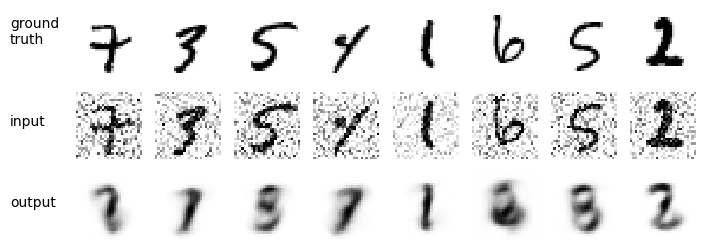

In [43]:
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.savefig(f"{absolutepath_to_results}/best-out.svg", bbox_inches="tight")
plt.show()

### Setting Parameters for Hyperband

Tuning Hyperband requires setting:

* `max_iter`: Number of epochs or data passes for training.
* Chunk size for the data array.

These determine the number of models evaluated and the overall search complexity.

### Comparison with Early Stopping Techniques

Compares Hyperband with:

* **Passive Search:** No early stopping, evaluates all models.
* **Incremental Search with Patience:** Early stops models that don't improve on a validation set.

Analyzes:

* Best model scores
* Visualizations of the best model's output

In [44]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

# n_workers = 32 or len(client.cluster.workers)
n_workers = len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, total_calls

(250, 29, 7401)

In [45]:
from dask_ml.model_selection import IncrementalSearchCV

passive_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=42
)

In [46]:
%%time
passive_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 0.7092676758766174
steps = 1, loss = 0.7851949334144592
steps = 1, loss = 2.9281046390533447
steps = 1, loss = 2.0382602214813232
steps = 1, loss = 1.7686915397644043
steps = 1, loss = 2.0014758110046387
steps = 1, loss = 2.4612090587615967
steps = 1, loss = 2.0172791481018066
steps = 1, loss = 2.428661346435547
steps = 1, loss = 1.8866915702819824
steps = 1, loss = 2.4018678665161133
steps = 1, loss = 1.0489938259124756
steps = 1, loss = 49.450504302978516
steps = 1, loss = 2.036716938018799
steps = 1, loss = 2.4377639293670654
steps = 1, loss = 49.915061950683594
steps = 1, loss = 2.382110834121704
steps = 1, loss = 1.9739691019058228
steps = 1, loss = 1.9683659076690674
steps = 1, loss = 1.9700000286102295
steps = 1, loss = 0.7204102277755737
steps = 1, loss = 2.392211437225342
steps = 1, loss = 2.286267042160034
steps = 1, loss = 1.928123950958252
steps = 1, loss = 1.1285806894302368
steps = 1, loss = 1.7917665243148804
steps = 1, loss = 1.9771867990493774
steps =

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=250, n_initial_parameters=29,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    random_state=42)

In [47]:
save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

In [48]:
# timing_stats = client.profile()
# with open(f"{absolutepath_to_results}/final-final-timings.json", "w") as f:
#     json.dump(timing_stats, f)

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [49]:
from dask_ml.model_selection import IncrementalSearchCV

patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=42,
)

In [50]:
%%time
patience_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 0.7015392184257507
steps = 1, loss = 2.0390679836273193
steps = 1, loss = 1.9451401233673096
steps = 1, loss = 1.9790714979171753
steps = 1, loss = 49.89901351928711
steps = 1, loss = 2.2601351737976074
steps = 1, loss = 1.9300516843795776
steps = 1, loss = 3.0525965690612793
steps = 1, loss = 1.9642322063446045
steps = 1, loss = 2.8931949138641357
steps = 1, loss = 3.145359516143799
steps = 1, loss = 1.9237724542617798
steps = 1, loss = 2.664077043533325
steps = 1, loss = 0.7161751985549927
steps = 1, loss = 2.6207008361816406
steps = 1, loss = 1.9601235389709473
steps = 1, loss = 0.7597142457962036
steps = 1, loss = 2.4687323570251465
steps = 1, loss = 1.9262726306915283
steps = 1, loss = 2.2864997386932373
steps = 1, loss = 1.119533896446228
steps = 1, loss = 2.8370532989501953
steps = 1, loss = 2.231611967086792
steps = 1, loss = 2.931516647338867
steps = 1, loss = 1.5063927173614502
steps = 1, loss = 3.0882468223571777
steps = 1, loss = 2.370192050933838
steps = 

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=250, n_initial_parameters=58,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    patience=25, random_state=42)

In [51]:
patience_search.best_score_

-1.9923282861709595

In [52]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())

In [53]:
timing_stats = client.profile()
with open(f"{absolutepath_to_results}/final-timings.json", "w") as f:
    json.dump(timing_stats, f)

In [54]:
data, fig = client.get_task_stream(plot="save", filename=f"{absolutepath_to_results}/task_stream.html")

In [55]:
import pandas as pd
df = pd.DataFrame(list(data))

In [56]:
df.head()

,stimulus_id,worker,nbytes,type,typename,metadata,thread,startstops,status,key
0,task-finished-1707309902.2195184,tcp://127.0.0.1:35239,2148,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140008744806144,"({'action': 'compute', 'start': 1707309898.278...",OK,_partial_fit-04849501-587d-4e65-81b0-661db8c57329
1,task-finished-1707309906.142285,tcp://127.0.0.1:40671,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140395937789696,"({'action': 'compute', 'start': 1707309895.645...",OK,_partial_fit-9af09ab7-1d0d-44c4-8411-bee171e6bda0
2,task-finished-1707309908.2306275,tcp://127.0.0.1:35239,2146,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140008744806144,"({'action': 'compute', 'start': 1707309902.224...",OK,_partial_fit-285c7a7a-b62b-4519-aeb9-f36dd20f66a8
3,task-finished-1707309910.1030731,tcp://127.0.0.1:40671,2147,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140395937789696,"({'action': 'compute', 'start': 1707309906.147...",OK,_partial_fit-7a2c1360-3b0e-4048-8304-e653b228b1b7
4,task-finished-1707309912.542559,tcp://127.0.0.1:35239,2148,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140008744806144,"({'action': 'compute', 'start': 1707309908.234...",OK,_partial_fit-12462be2-5d9e-4f0a-8c96-45691442c2b7


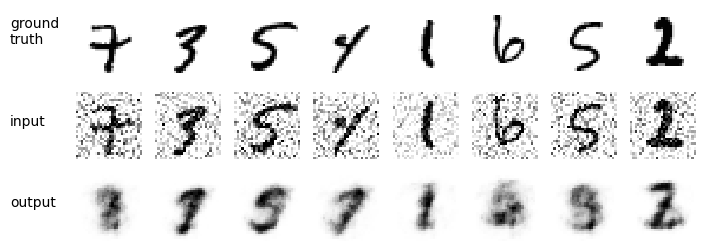

In [57]:
clean_hat = patience_search.best_estimator_.predict(noisy_test)

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.savefig(f"{absolutepath_to_results}/patience-best-out.svg", bbox_inches="tight")
plt.show()

### Conclusion

This notebook demonstrates hyperparameter optimization for image denoising using Dask-ML. It compares different algorithms and highlights the importance of choosing appropriate parameters for each approach.

This enhanced script provides clear explanations, code comments, and visualizations to effectively teach hyperparameter optimization concepts and best practices.